In [1]:
# For folder processing
from scipy.io import loadmat
import os
import tarfile
import urllib.request

# For Image Processing and Display
from PIL import Image
from matplotlib import pyplot as plt
%matplotlib inline 
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# For Visualization
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected = True)
from jupyter_plotly_dash import JupyterDash
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output

# For data processing
from collections import defaultdict
import numpy as np
import pandas as pd

# For Training Image Classification Model
import keras
import os.path
from keras.models import load_model
from keras.applications.resnet50 import preprocess_input, decode_predictions, ResNet50

from sklearn.preprocessing import LabelBinarizer
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
import numpy as np

Using TensorFlow backend.


In [2]:
def retrieve_dataset(url, target_folder):
    """
    Function:
        - Creates a subdirectory "./Data" in the current working directory if it doesn't exist already
        - Downloads the dataset into the newly created folder
        
    Arguments:
        - url: (str) URL of dataset
        - target_folder: (str) relative path of target folder
        
    Return:
        - A "./Data" folder containing the zipped dataset
    """
    # Path to downloaded file
    target_file = target_folder + "/" + url.split("/")[-1]
    
    # If the dataset has already been downloaded, terminate function
    if os.path.exists(target_file):
        print("Data has already been downloaded at '{}'.".format(target_file))
        return
    
    # If target folder doesn't exist yet, create it
    if not os.path.exists(target_folder):
        os.mkdir(target_folder.split("/")[-1])
        print("Created a new folder at '{}'.".format(target_folder))
        
    # Downloading the dataset
    print("Downloading dataset from '{}', please wait...".format(url))
    urllib.request.urlretrieve(url, target_file)  
    print("File successfully downloaded to '{}''.".format(path))

In [3]:
url_1 = "http://imagenet.stanford.edu/internal/car196/cars_train.tgz" 
target_folder = "./data"

In [4]:
# Load matlab file conntaining that maps the label and full name of the car
original_dict_metadata = loadmat('devkit/cars_meta.mat')
#dict_meta = dictionary containing metadata

In [5]:
dict_idx_carname = {int(index+1):classname[0] for index, classname in enumerate(original_dict_metadata["class_names"][0])}

In [6]:
dict_idx_carname

{1: 'AM General Hummer SUV 2000',
 2: 'Acura RL Sedan 2012',
 3: 'Acura TL Sedan 2012',
 4: 'Acura TL Type-S 2008',
 5: 'Acura TSX Sedan 2012',
 6: 'Acura Integra Type R 2001',
 7: 'Acura ZDX Hatchback 2012',
 8: 'Aston Martin V8 Vantage Convertible 2012',
 9: 'Aston Martin V8 Vantage Coupe 2012',
 10: 'Aston Martin Virage Convertible 2012',
 11: 'Aston Martin Virage Coupe 2012',
 12: 'Audi RS 4 Convertible 2008',
 13: 'Audi A5 Coupe 2012',
 14: 'Audi TTS Coupe 2012',
 15: 'Audi R8 Coupe 2012',
 16: 'Audi V8 Sedan 1994',
 17: 'Audi 100 Sedan 1994',
 18: 'Audi 100 Wagon 1994',
 19: 'Audi TT Hatchback 2011',
 20: 'Audi S6 Sedan 2011',
 21: 'Audi S5 Convertible 2012',
 22: 'Audi S5 Coupe 2012',
 23: 'Audi S4 Sedan 2012',
 24: 'Audi S4 Sedan 2007',
 25: 'Audi TT RS Coupe 2012',
 26: 'BMW ActiveHybrid 5 Sedan 2012',
 27: 'BMW 1 Series Convertible 2012',
 28: 'BMW 1 Series Coupe 2012',
 29: 'BMW 3 Series Sedan 2012',
 30: 'BMW 3 Series Wagon 2012',
 31: 'BMW 6 Series Convertible 2007',
 32: 

In [7]:
carname_list = dict_idx_carname.values()
dict_brand_count = defaultdict(int)
for carname in carname_list:
    brand = carname.split(" ")[0]
    dict_brand_count[brand] += 1

In [8]:
# Load matlab file
original_dict_traindata = loadmat('devkit/cars_train_annos.mat')

master_dict_traindata = {}
# Annotations = {"fname": {"bbox_xmin": 12, "bbox_xmax": 13, "bbox_y1": , "bbox_y2"}}

master_dict_traindata = {image[5][0]:{"bbox_xmin": image[0][0][0], "bbox_xmin": image[0][0][0], "bbox_xmax": image[1][0][0],"bbox_ymin": image[2][0][0],"bbox_ymax": image[3][0][0],"classnumber": image[4][0][0], "classname": dict_idx_carname[image[4][0][0]]} for image in original_dict_traindata["annotations"][0]}

In [9]:
def load_images_to_dictionary(image_path = "./data", dictionary = master_dict_traindata):
    """
    Function: 
        -loads images from the target folder
        -resizes and preprocesses the images 
        -append the original and preprocssed images, file names and labels into a "dataset"
    Arguments: 
        -folder (str): the directory containing the images
        -label (str): the class of images
        -width (int): desired width after resizing
        -height (int): desired height after resizing
    Returns: 
        -dataset (list): list of tuples: (nd.array of original image, nd.array of preprocessed image, image name, image label)
    """
    image_list = os.listdir(image_path)
    
    for index, filename in enumerate(image_list):
        img = Image.open(os.path.join(image_path,filename))
        img_np = np.array(img)
        dictionary[filename]["np_image"] = img_np
        #dictionary[filename]["preprocessed_image"] = preprocess_input(img_np)
    return dictionary

In [10]:
master_dict_traindata = load_images_to_dictionary()

In [11]:
df_train = pd.DataFrame.from_dict(data = master_dict_traindata, orient = "index")

In [12]:
df_train.head()

,bbox_xmin,bbox_xmax,bbox_ymin,bbox_ymax,classnumber,classname,np_image
00001.jpg,39,116,569,375,14,Audi TTS Coupe 2012,"[[[101, 119, 123], [98, 116, 120], [93, 111, 1..."
00002.jpg,36,116,868,587,3,Acura TL Sedan 2012,"[[[164, 169, 175], [166, 171, 177], [169, 174,..."
00003.jpg,85,109,601,381,91,Dodge Dakota Club Cab 2007,"[[[231, 231, 231], [244, 244, 244], [234, 234,..."
00004.jpg,621,393,1484,1096,134,Hyundai Sonata Hybrid Sedan 2012,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
00005.jpg,14,36,133,99,106,Ford F-450 Super Duty Crew Cab 2012,"[[[136, 167, 196], [136, 167, 196], [138, 169,..."


In [13]:
df_train.loc["00001.jpg", "classname"]

'Audi TTS Coupe 2012'

In [14]:
def show_image_in_dataframe(dataframe = df_train, idx = 0):
    """
    Function:
        - shows an image from the dataset and its label
    Arguments:
        - dataset (list): list of tuples: (nd.array of original image, nd.array of preprocessed image, image name, image label)
    Returns:
         none, but the function will show the original and preprocessedimage, its name and its label
    """
    
    filename = list(dataframe.index)[idx]
    
    fig, ax = plt.subplots(figsize=(9,5))
    ax.imshow(df_train.loc[filename, 'np_image'], interpolation='nearest')
    ax.set_title("Your original image after resizing:")
    plt.show()
    print(f"Image file name: {filename}")
    print(f"Image class: {df_train.loc[filename, 'classname']}")

In [15]:
_ = interact(show_image_in_dataframe, dataframe = fixed(df_train), idx=widgets.IntSlider(min=0,max=len(master_dict_traindata)-1,step=1,value=50), continous_update = False)

interactive(children=(IntSlider(value=50, description='idx', max=8143), Output()), _dom_classes=('widget-inter…

In [16]:
dict_classname_count = defaultdict(int)
for datapoint in master_dict_traindata.values():
    classname = datapoint["classname"]
    dict_classname_count[classname] += 1


trace = go.Bar(x = list(dict_classname_count.keys()), y = list(dict_classname_count.values()))
data = [trace]
layout = go.Layout(title = "Count Per Class", xaxis = {
        'categoryorder': 'array',
        'categoryarray': [x for _, x in sorted(zip(list(dict_classname_count.values()), list(dict_classname_count.keys())))]
    })


figure = go.Figure(data = data, layout = layout)
iplot(figure)

In [17]:
def load_resnet50_model():
    """
    Function:
        - If the ResNet50 model isn't already saved, the function will download the model, save it to ./model/ResNet50.h5 and return it
        - If model is already saved, the function will simply return the model
    Return:
        - The original ResNet50 model
    """
    model_path = "./model/ResNet50.h5"
    if os.path.exists(model_path):
        print(f"Retrieving saved model from {model_path}...")
        model = load_model(model_path)
        print("Saved model retrieved!")
        return model
    else:
        from keras.applications.resnet50 import ResNet50
        print("Downloading model...")
        os.makedirs ("./model")
        model = ResNet50(weights='imagenet')
        model.save(model_path)
        print(f"Model retrieved and saved in {model_path}")
        return model

In [18]:
resnet50 = load_resnet50_model()

Retrieving saved model from ./model/ResNet50.h5...
Instructions for updating:
Colocations handled automatically by placer.
Saved model retrieved!


/home/meraldoantonio/anaconda3/envs/grabenv/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning:

No training configuration found in save file: the model was *not* compiled. Compile it manually.



In [19]:
resnet50.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [20]:
def test_model(model = resnet50, dataframe = df_train, idx = 0):
    
    
    # Grab a sample image from the dataset and show it
    print("==================================")
    print("Image:")
    show_image_in_dataframe(dataframe, idx)
    print("==================================")
    
    # Get the numpy array of the sample image
    
    filename = list(dataframe.index)[idx]
    
    
    
    sample_image = df_train.loc[filename, 'np_image'].copy()
    sample_image = np.resize(sample_image,(224, 224, 3))
    sample_image = preprocess_input(sample_image)
    sample_image = np.expand_dims(sample_image, axis=0)


    # Input it to the chosen model
    preds = model.predict(sample_image)
    
    # Get the top 5 prediction classes and their corresponding probabilities
    prediction_classes = [item[1] for item in decode_predictions(preds, top=5)[0]]
    prediction_probabilities = [item[2]*100 for item in decode_predictions(preds, top=5)[0]]
    
    # Show these probabilities as interactive bar charts
    trace = go.Bar(x = prediction_classes, y = prediction_probabilities)
    data = [trace]
    layout =  go.Layout(title = "Probabilities of top 5 predictions", xaxis=dict(title= 'Car class',
                                 tickfont= dict(family='Old Standard TT, serif',
                                                                              size=15,
                                                                              color='black')),
                        yaxis=dict(title= 'Probability (%)', hoverformat = '.2f'),
                        autosize=True,
                        width=600,
                        height=400)
    figure = go.Figure(data = data, layout = layout)
    iplot(figure)


Image:


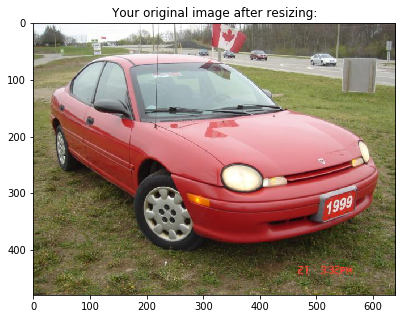

Image file name: 00016.jpg
Image class: Plymouth Neon Coupe 1999


In [26]:
test_model(model = resnet50, dataframe = df_train, idx = 15)

In [22]:
len(df_train)

8144

In [27]:
_ = interact(test_model, model = fixed(resnet50), dataframe = fixed(df_train), idx=widgets.IntSlider(min=0,max=len(df_train)-1,step=1,value=50), continous_update = False)

interactive(children=(IntSlider(value=50, description='idx', max=8143), Output()), _dom_classes=('widget-inter…

In [28]:
def load_untrained_transfer_model():
    """
    If model isn't saved - download model, save it to current directory and return it
    If model already exists, simply return the model
    """
    model_path = "./model/Untrained_transfer.h5"
    if os.path.exists(model_path):
        print(f"Retrieving saved model from {model_path}")
        untrained_transfer_model = load_model(model_path)
        print("Saved model retrieved!")
        return untrained_transfer_model
    else:
        ## Build model
        print("Downloading and building model...")
        untrained_transfer_model = Sequential()
        untrained_transfer_model.add(ResNet50(include_top = False, pooling = "avg", weights = "imagenet"))
        untrained_transfer_model.add(Dense(512, activation = "relu"))
        untrained_transfer_model.add(Dropout(0.5))
        untrained_transfer_model.add(Dense(512, activation = "relu"))
        untrained_transfer_model.add(Dropout(0.5))
        untrained_transfer_model.add(Dense(6, activation = "softmax"))
        
        untrained_transfer_model.layers[0].trainable = False
        
        ## Save model
        print(f"Model built and saved in {model_path}")
        untrained_transfer_model.save(model_path)
        return untrained_transfer_model

In [29]:
transfer_model = load_untrained_transfer_model()

Retrieving saved model from ./model/Untrained_transfer.h5
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Saved model retrieved!


In [30]:
transfer_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 3078      
Total params: 24,902,534
Trainable params: 24,849,414
Non-trainable params: 53,120
___________________________________________________________

In [31]:
transfer_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [52]:
def preprocess_image(np_image):
    resized_np_image = np.resize(np_image,(224,224,3))
    preprocessed_np_image = preprocess_input(resized_np_image)
    return preprocessed_np_image

In [ ]:
df_train["preprocessed_np_image"] = df_train["np_image"].map(preprocess_image)

In [50]:
df_train.columns

Index(['bbox_xmin', 'bbox_xmax', 'bbox_ymin', 'bbox_ymax', 'classnumber',
       'classname', 'np_image'],
      dtype='object')

In [ ]:
sample_image = df_train.loc[filename, 'np_image'].copy()
sample_image = np.resize(sample_image,(224, 224, 3))
sample_image = preprocess_input(sample_image)
sample_image = np.expand_dims(sample_image, axis=0)

In [43]:
X = np.stack([image for image in df_train["np_image"]])
print(f"Shape of training set: {X.shape}")

ValueError: all input arrays must have the same shape

In [39]:
# Combine all the labels from our six datasets
encoder = LabelBinarizer()
y = encoder.fit_transform(df_train["classnumber"])
print(f"Shape of label set: {y.shape}")

Shape of label set: (8144, 196)


In [40]:
max_epoch = 20
filepath="./model/trained_model-{epoch:02d}-{val_acc:.2f}.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
history = transfer_model.fit(x = X, y = y, validation_split = 0.1, epochs = max_epoch, callbacks = callbacks_list) 

ValueError: Error when checking input: expected resnet50_input to have 4 dimensions, but got array with shape (8144, 1)